In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the training data into feature matrix, class labels, and event ids:

In [2]:
import datetime
from proj1_helpers import *

DATA_TRAIN_PATH = 'data/train.csv' 
y, X, ids = load_csv_data(DATA_TRAIN_PATH)
X.shape

(250000, 30)

In [3]:
def standardize(x, mean_x=None , std_x=None):
    """Standardize the original data set."""
    if mean_x==None:
        mean_x = np.mean(x)
        std_x = np.std(x)
        
    x = x - mean_x     
    x = x / std_x
    return x, mean_x, std_x

def min_max_scaler(x):
    m,M=np.min(x),np.max(x)
    return (x-m)/(M-m)

def build_model_data(y, x):
    """Form (y,tX) to get regression data in matrix form."""
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]
    return y, tx


# Data Exploration

In [4]:
#handmade varaible containing the names of the columns of X, it might be usefull for us to compare datasets
feature_names=['DER_mass_MMC','DER_mass_transverse_met_lep','DER_mass_vis','DER_pt_h','DER_deltaeta_jet_jet','DER_mass_jet_jet','DER_prodeta_jet_jet','DER_deltar_tau_lep','DER_pt_tot','DER_sum_pt','DER_pt_ratio_lep_tau','DER_met_phi_centrality','DER_lep_eta_centrality','PRI_tau_pt','PRI_tau_eta','PRI_tau_phi','PRI_lep_pt','PRI_lep_eta','PRI_lep_phi','PRI_met','PRI_met_phi','PRI_met_sumet','PRI_jet_num','PRI_jet_leading_pt','PRI_jet_leading_eta','PRI_jet_leading_phi','PRI_jet_subleading_pt','PRI_jet_subleading_eta','PRI_jet_subleading_phi','PRI_jet_all_pt']

## Missing value ratio
let's first have a look a the number of missing values in each feature (columns) of our dataset. Features with a high ratio (#missing values/#values) are unlikely to carry much information 

In [5]:
def missing_values_r(v):
    'compute the missing values ratio for a given vector v'
    return 1-np.sum(v>-999)/len(v)

ratios={} #dictionary linkng a feature name with its missing values ratio
for feature_index in range(len(X[0])):
    ratios[feature_index]=missing_values_r(X[:,feature_index])
ratios   

{0: 0.15245600000000004,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.709828,
 5: 0.709828,
 6: 0.709828,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.709828,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.399652,
 24: 0.399652,
 25: 0.399652,
 26: 0.709828,
 27: 0.709828,
 28: 0.709828,
 29: 0.0}

We imediatly see that the features of indices 4,5,6,26,27,28,12 have a 70 percent rate of missing values. We will probably discard them during the preprocessing process. 

In fact we can already discard them, thes is no use of keeping them during the Data exploration process. To remove the we simply use a threshold t that will be the upper bound on 'acceptable' missing values ration.

Note that t is an hyperparameter of our future model

In [6]:
#threshold
t=0.7
columns_to_delete=[]
for feature_index in ratios:
    if ratios[feature_index]>t:
        columns_to_delete.append(feature_index)

    
X=np.delete(X,obj=columns_to_delete,axis=1)

#we also have to update the columns names since we removed some of them
feature_names=np.delete(feature_names,obj=columns_to_delete,axis=0)

In [7]:
X.shape

(250000, 23)

## Variance
In this section we study the variance of each feature, low variance features are unlikely to carry much information

In [8]:
stds=[]
for feature_index in range(np.shape(X)[1]):
    feature=min_max_scaler(X[:,feature_index])
    stds.append(np.std(feature))
stds

[0.1854587001754863,
 0.05121880219110957,
 0.03040055105199512,
 0.02245346622938694,
 0.14297106516097688,
 0.007856598610766506,
 0.06405479075633186,
 0.04282374810776731,
 0.4220588573560675,
 0.03010719369283506,
 0.24300965129471172,
 0.2891087541128481,
 0.041299037894752456,
 0.252591776861119,
 0.28908460050752877,
 0.011572395716218457,
 0.2883862313077915,
 0.06355794595441264,
 0.32580811684589234,
 0.2514476847137123,
 0.48763108616987993,
 0.4882874811550058,
 0.06000580738649002]

## Correlations
here we study the different correlations because...

In [9]:
def correlation(a,b):
    #since we want to measure linear correlation between features and target we will use the pearson corrlation provided in numpy 
    return np.corrcoef(a,b)[0][1]

#### Correlation Feature/Target
lets first check which features are correlated or not with the target vector 'y'. Uncorrelated features have no use to predict 'y'

In [10]:
correlations=[]

for feature_index in range(len(X[0])):
    #contains one feature of the dataset, namely one column of Tx
    feature=X[:,feature_index]
    
    #first of all we have to filter out all the values equal to -999 (unknown values)
    indices=feature>-999
    feature=feature[indices]
    target=y[indices]
    
    corr = correlation(feature,target)
    
    correlations.append(corr)

#### Mutual correlation between features 
Having a look at the mutual correlation between features is important because if two of them are highly correlated we could just use one and simplify the model

In [466]:
correlation_matrix=[]
for index1 in range(len(X[0])):
    correlations_row=[]#row of the correlation matrix
    for index2 in range(len(X[0])):
        #contains one feature of the dataset, namely one column of Tx
        feature1=X[:,index1]
        feature2=X[:,index2]

        #first of all we have to filter out all the values equal to -999 (unknown values)
        indices=(feature1>-999) * (feature2>-999)
        feature1=feature1[indices]
        feature2=feature2[indices]
        
        corr = correlation(feature1,feature2)
        
        correlations_row.append(corr)
    correlation_matrix.append(correlations_row)

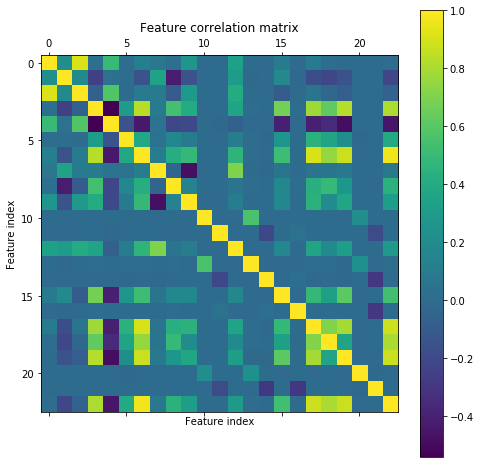

In [467]:
plt.figure(figsize=(8,8))
plt.matshow(correlation_matrix,fignum=1)
plt.colorbar()
plt.title("Feature correlation matrix")
plt.ylabel("Feature index")
plt.xlabel("Feature index")
plt.show()

In [468]:
threshold=0.8
features_to_delete=[]
for feature1_index in range(np.shape(correlation_matrix)[1]):
    for feature2_index in range(np.shape(correlation_matrix)[0]):
            corr=correlation_matrix[feature1_index][feature2_index]
            if np.abs(corr)>threshold and feature1_index>feature2_index:
                features_to_delete.append(feature2_index)

features_to_delete=np.unique(features_to_delete)
features_to_delete

array([ 0,  3,  6, 17, 18, 19])

In [469]:
X=np.delete(X,obj=features_to_delete,axis=1)

#we also have to update the columns names since we removed some of them
feature_names=np.delete(feature_names,obj=features_to_delete,axis=0)

We can see high values of correlation on the diagonal, these come from the auto-correlation of the features. The most interesting information that we see here is the others values that are close to one, these correspond to high correlations between two different features.

Note that the Feature correlation matrix is symetric 

## Correlations
In this section we will study the distributions (feature by feature) of the dataset. The result may help us to decide what to do with the missing values (-999) 

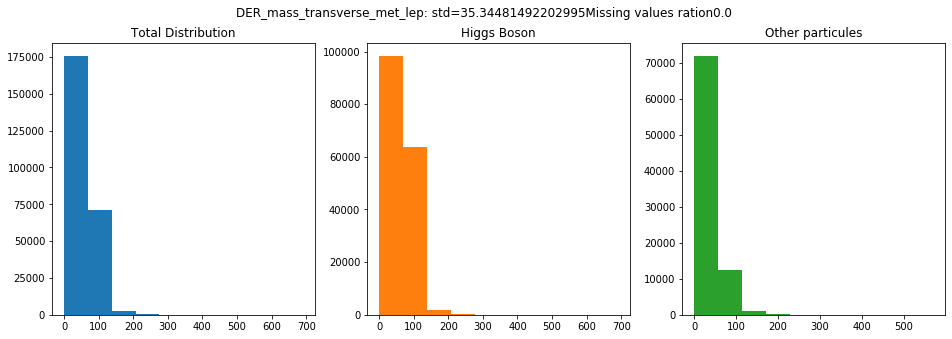

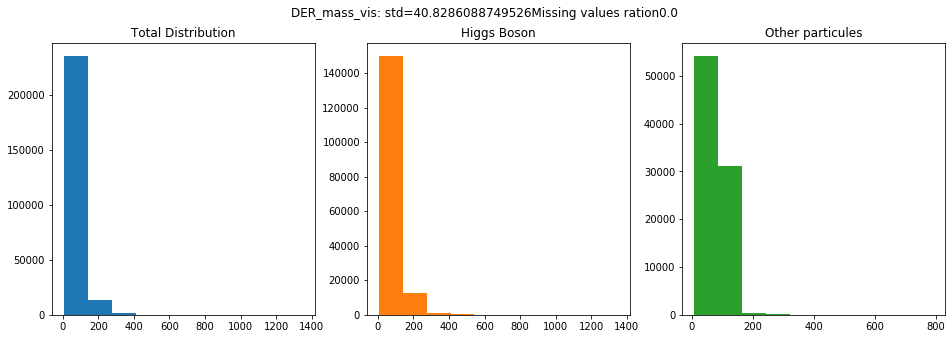

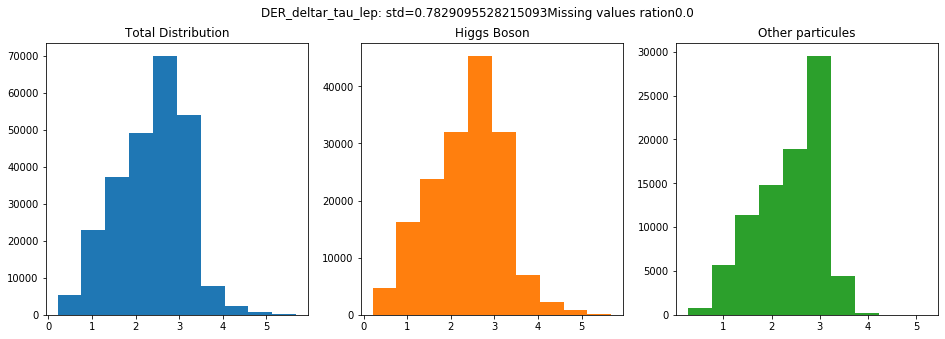

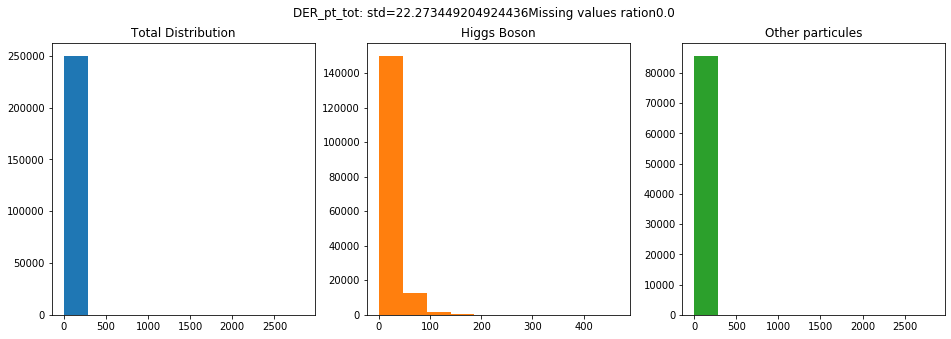

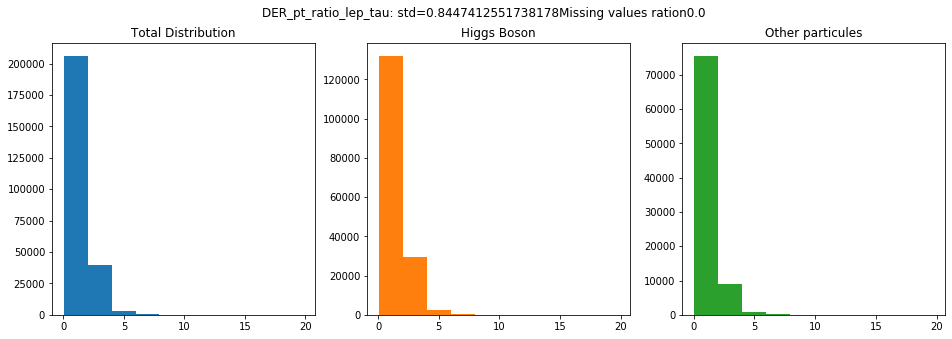

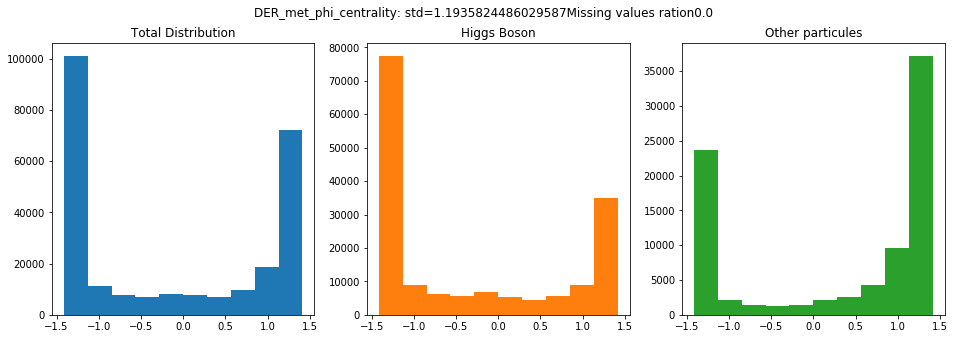

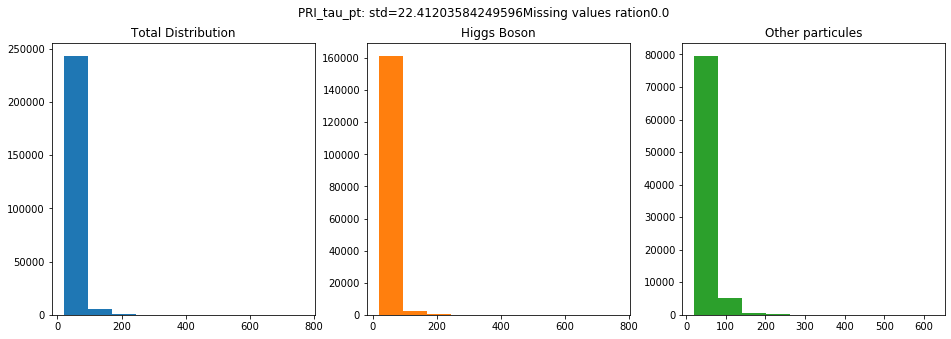

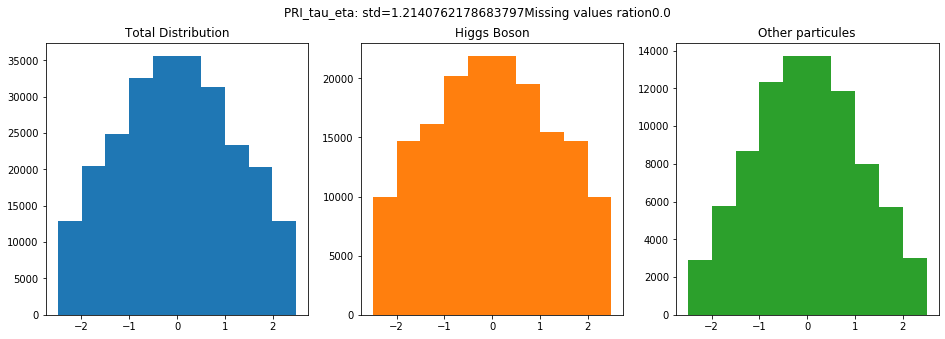

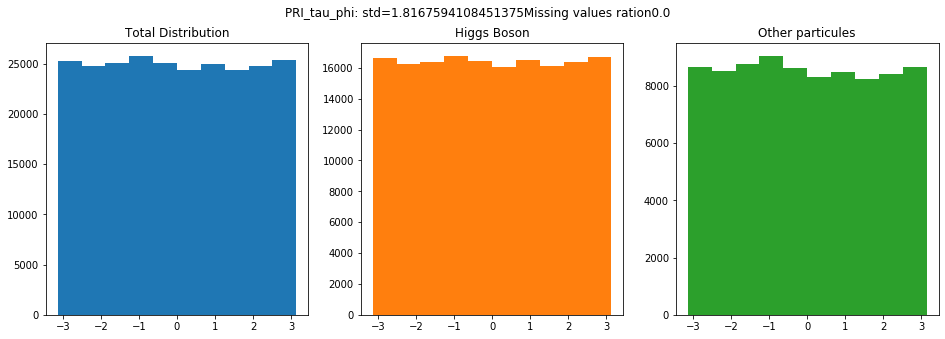

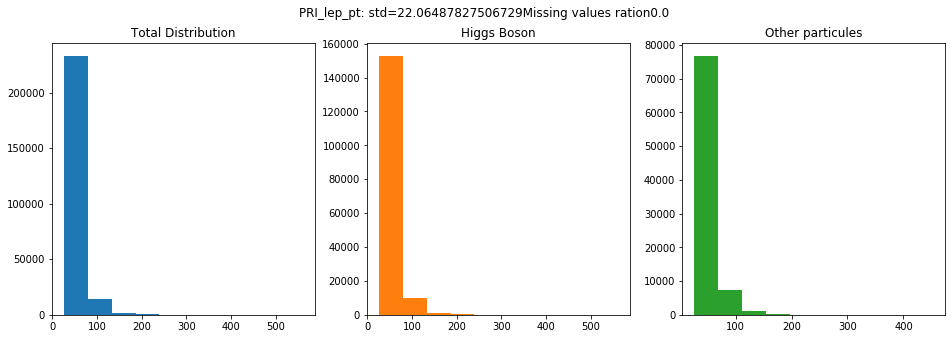

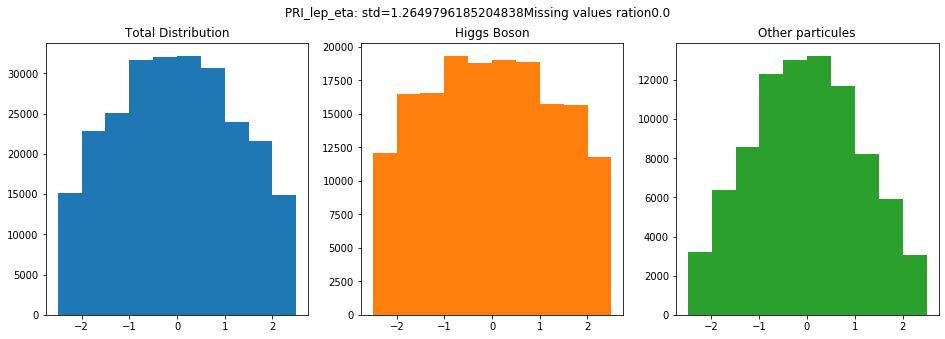

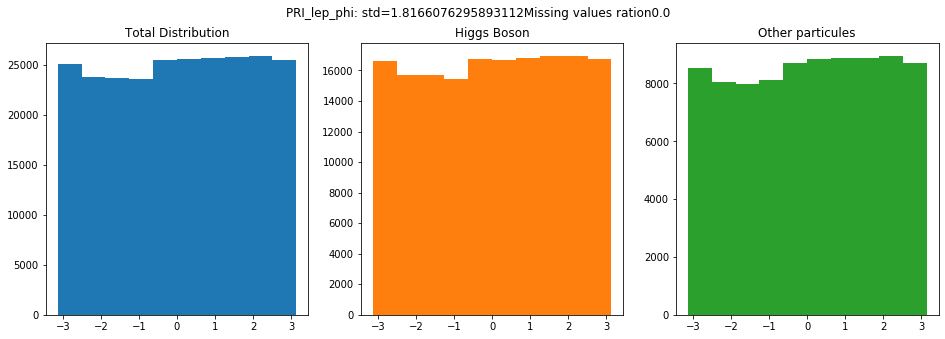

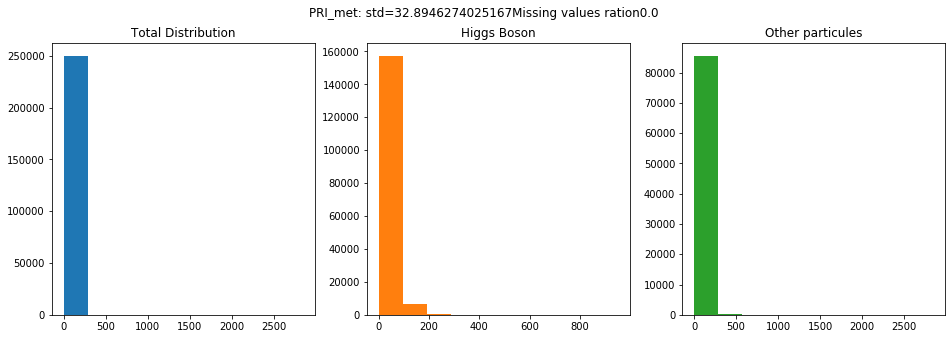

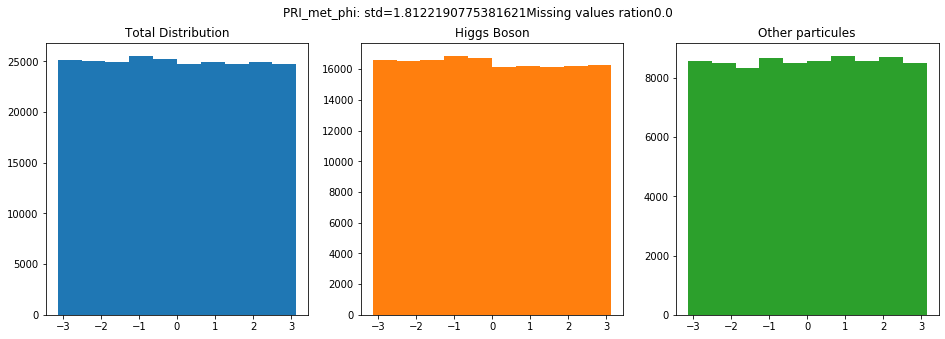

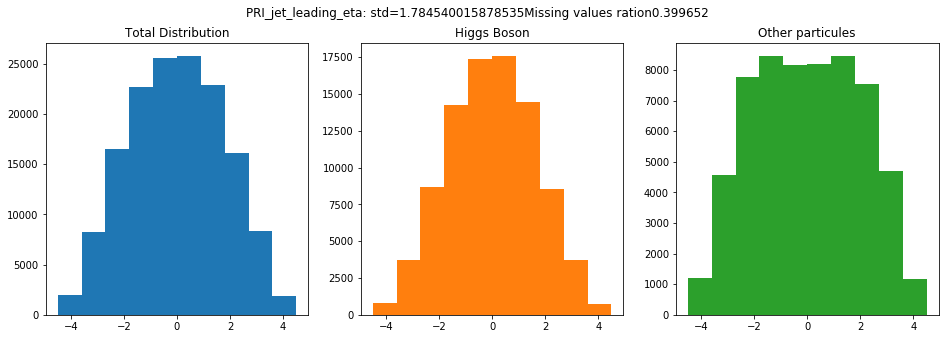

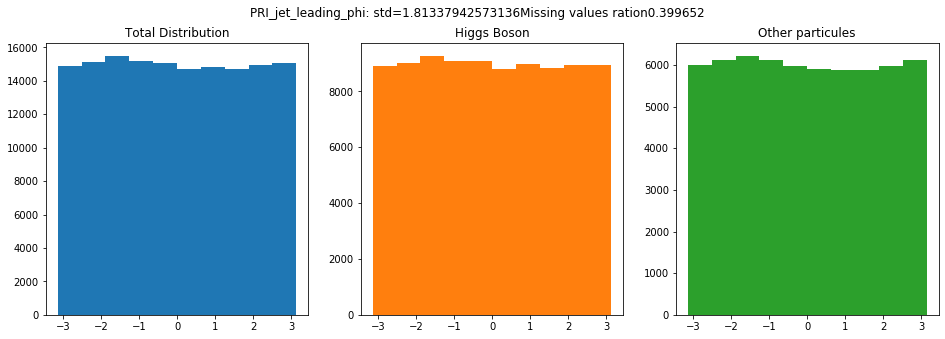

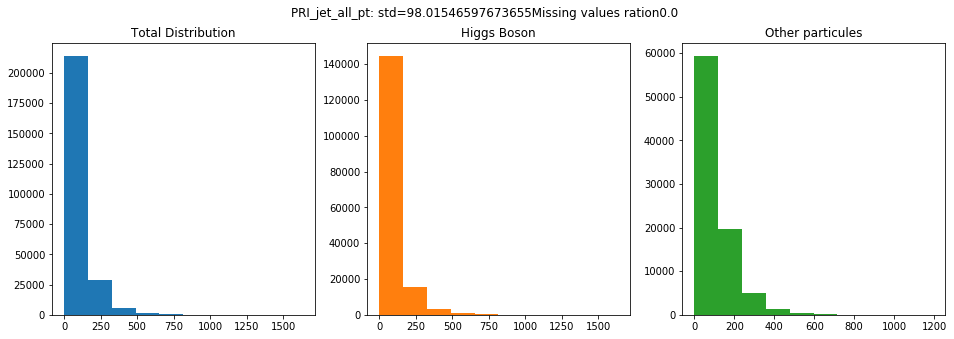

In [470]:
def plotHistogram(index, title,X,labels, filterMissingValues=True):
    extraCond = np.logical_or(np.full(labels.shape, not filterMissingValues, dtype=bool), (X[:,index]>-990))
    fig, axs = plt.subplots(1, 3,figsize=(16,5))
    axs[0].hist(X[extraCond,index])
    axs[0].set_title('Total Distribution')
    axs[1].hist(X[np.logical_and(labels==-1, extraCond),index], color='tab:orange')
    axs[1].set_title('Higgs Boson')
    axs[2].hist(X[np.logical_and(labels==1, extraCond),index], color='tab:green')
    axs[2].set_title('Other particules')
    fig.suptitle(title+ ": std="+ str(np.std(X[extraCond,index]))+"Missing values ration"+ str(missing_values_r(X[:,index])))

    #******************
    #plt.hist(X[:,index])
    plt.show()

for index in range(X.shape[1]):
    plotHistogram(index,feature_names[index],X,y)

# Data preprocessing

## Features extraction 
Reducing the number of features in the dataset could improve the precisiion of our future model (TODO : explai why) 

## Polynomial feature expansion

In [91]:
def expand(x):
    'expand the features (columns) of a given matrix x'
    #array containing all create features plus the old ones 
    features=[x,]
    for feature1_index in range(x.shape[1]):
        for feature2_index in range(x.shape[1]):
            #condition to avoid duplicate (xy=yx)
            if feature1_index>=feature2_index:
                feature1=x[:,feature1_index]
                feature2=x[:,feature2_index]
                new_feature=feature1*feature2
                features.append(new_feature)
    return np.column_stack(features)

In [92]:
#indices of all data points that does'nt contain any values equal to -999 (unknown values)
indices=np.all(X>-999,axis=1)

train_part=0.6
split_index=int(len(X[indices])*train_part)

train_set=X[indices][:split_index,]
train_target=y[indices][:split_index,]

test_set=X[indices][split_index:,]
test_target=y[indices][split_index:,]
print("train and test sets shape before expansion:",train_set.shape,test_set.shape)


train and test sets shape before expansion: (82857, 23) (55239, 23)


In [93]:
train_set=expand(train_set)
test_set=expand(test_set)
print("train and test sets shape after expansion:",train_set.shape,test_set.shape)

train and test sets shape after expansion: (82857, 299) (55239, 299)


In [94]:


train_set,tX_mean,tX_std=standardize(train_set)
test_set,m,s=standardize(test_set, mean_x=tX_mean , std_x=tX_std)

train_target,train_set =build_model_data(train_target,train_set)
test_target,test_set =build_model_data(test_target,test_set)

print("Train set,target",np.shape(train_set),np.shape(train_target))
print("Test set,target",np.shape(test_set),np.shape(test_target))

Train set,target (82857, 300) (82857,)
Test set,target (55239, 300) (55239,)


# Do your thing crazy machine learning thing here :) ...

In [95]:
#Compute the loss using mse
def compute_loss(y, tx, w):
    e=y-tx.dot(w)
    n=len(y)
    return 1/(2*n)*e.dot(e)

#Compute the gradient of the loss function (mse)
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e=y-tx.dot(w)
    grd=tx.T.dot(e)
    return -(1/len(y))*grd 

In [96]:
#Gradient descent algorithm
def least_squares_GD(y, tx, initial_w,max_iters, gamma):

    w=initial_w
    
    for n_iter in range(max_iters):
        grd=compute_gradient(y,tx,w)
        w=w-gamma*grd
        
        loss=compute_loss(y,tx,w)
        if n_iter%10==0:
            print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
                  bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    
    loss=compute_loss(y,tx,w)
    return w,loss
    

In [97]:
def compute_stoch_least_squares_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""   
    my=None
    mx=None
    for mmini_y,mini_x in batch_iter(y, tx, batch_size=1):
            my=mmini_y
            mx=mini_x
    
    return compute_gradient(my, mx, w)


def least_squares_SGD(y, tx, initial_w, batch_size, max_iters, gamma):
    "Gradient descent algorithm"
    w=initial_w
    for i in range(max_iters):
        grd=gamma*compute_stoch_least_squares_gradient(y,tx,w)
        w=w-grd
    loss=compute_loss(y,tx,w)
    
    return w, loss

In [98]:
max_iters = 4000
gamma = 0.005
w_initial = np.zeros(len(train_set[0]))

weights,loss=least_squares_GD(train_target,train_set, w_initial,max_iters, gamma)

Gradient Descent(0/3999): loss=0.49611616045030377, w0=-0.0007374754094403612, w1=0.00013279171103531068
Gradient Descent(10/3999): loss=0.4816321501562385, w0=-0.004925593109995317, w1=0.0008927836201093689
Gradient Descent(20/3999): loss=0.47503540903977987, w0=-0.007487382723770083, w1=0.001363866154157835
Gradient Descent(30/3999): loss=0.47093992490543024, w0=-0.009231892067292581, w1=0.0016891525725528265
Gradient Descent(40/3999): loss=0.46790461247636644, w0=-0.010544353609098235, w1=0.0019369938008954486
Gradient Descent(50/3999): loss=0.4654293026315449, w0=-0.011606140577783855, w1=0.0021396840011171387
Gradient Descent(60/3999): loss=0.4633015769240628, w0=-0.012507131901117442, w1=0.0023132998274465436
Gradient Descent(70/3999): loss=0.4614172847607302, w0=-0.013295100439209829, w1=0.0024664313743849426
Gradient Descent(80/3999): loss=0.4597194814195666, w0=-0.013997698700288068, w1=0.0026040761946985094
Gradient Descent(90/3999): loss=0.45817379830841637, w0=-0.0146324395

Gradient Descent(800/3999): loss=0.4356715805966223, w0=-0.027112965453773997, w1=0.005738936905624128
Gradient Descent(810/3999): loss=0.435619074089599, w0=-0.02716477434442982, w1=0.005758898609484748
Gradient Descent(820/3999): loss=0.4355675621206788, w0=-0.027215275608050128, w1=0.005778621172006935
Gradient Descent(830/3999): loss=0.4355170014175744, w0=-0.02726450440381688, w1=0.0057981109066240835
Gradient Descent(840/3999): loss=0.43546735122239, w0=-0.027312494929909253, w1=0.005817373955417159
Gradient Descent(850/3999): loss=0.435418573130901, w0=-0.027359280448328593, w1=0.005836416293537987
Gradient Descent(860/3999): loss=0.43537063094253753, w0=-0.027404893309125888, w1=0.005855243733524841
Gradient Descent(870/3999): loss=0.4353234905203404, w0=-0.027449364974058282, w1=0.005873861929515241
Gradient Descent(880/3999): loss=0.43527711966020305, w0=-0.027492726039697313, w1=0.005892276381360151
Gradient Descent(890/3999): loss=0.4352314879687684, w0=-0.02753500626000792

Gradient Descent(1600/3999): loss=0.4329939051422937, w0=-0.028951582442091017, w1=0.006909250222506681
Gradient Descent(1610/3999): loss=0.4329705958546399, w0=-0.028959394119851517, w1=0.006921017636175929
Gradient Descent(1620/3999): loss=0.4329474330802609, w0=-0.02896703557176394, w1=0.006932751736963366
Gradient Descent(1630/3999): loss=0.4329244149926584, w0=-0.028974510652978454, w1=0.006944453239331544
Gradient Descent(1640/3999): loss=0.4329015398031354, w0=-0.028981823120042563, w1=0.006956122839885707
Gradient Descent(1650/3999): loss=0.4328788057595568, w0=-0.028988976633671556, w1=0.0069677612178695204
Gradient Descent(1660/3999): loss=0.4328562111451656, w0=-0.028995974761436845, w1=0.006979369035646204
Gradient Descent(1670/3999): loss=0.43283375427745174, w0=-0.029002820980374648, w1=0.006990946939165504
Gradient Descent(1680/3999): loss=0.432811433507075, w0=-0.02900951867951749, w1=0.007002495558416914
Gradient Descent(1690/3999): loss=0.4327892472168324, w0=-0.02901

Gradient Descent(2390/3999): loss=0.43149824635207024, w0=-0.029246173264667313, w1=0.007774015429068594
Gradient Descent(2400/3999): loss=0.431482763458625, w0=-0.02924744837094899, w1=0.007784448012004442
Gradient Descent(2410/3999): loss=0.43146734694353717, w0=-0.029248689878186372, w1=0.007794873089519415
Gradient Descent(2420/3999): loss=0.4314519962550807, w0=-0.02924989840438588, w1=0.007805290783176423
Gradient Descent(2430/3999): loss=0.43143671084800045, w0=-0.029251074554986052, w1=0.007815701212170623
Gradient Descent(2440/3999): loss=0.4314214901834101, w0=-0.02925221892314613, w1=0.0078261044933823
Gradient Descent(2450/3999): loss=0.4314063337286901, w0=-0.029253332090027118, w1=0.0078365007414284
Gradient Descent(2460/3999): loss=0.43139124095738846, w0=-0.02925441462506562, w1=0.007846890068712746
Gradient Descent(2470/3999): loss=0.4313762113491244, w0=-0.029255467086240546, w1=0.007857272585474981
Gradient Descent(2480/3999): loss=0.4313612443894936, w0=-0.029256490

Gradient Descent(3180/3999): loss=0.4304438483550944, w0=-0.029278280594971815, w1=0.00858202357110869
Gradient Descent(3190/3999): loss=0.4304323029488247, w0=-0.029278121073525478, w1=0.008592107536034864
Gradient Descent(3200/3999): loss=0.43042079443691783, w0=-0.0292779530819504, w1=0.008602189076153434
Gradient Descent(3210/3999): loss=0.43040932257417946, w0=-0.029277776758863713, w1=0.008612268220897983
Gradient Descent(3220/3999): loss=0.430397887117624, w0=-0.029277592240430955, w1=0.008622344999213145
Gradient Descent(3230/3999): loss=0.43038648782645134, w0=-0.029277399660410954, w1=0.008632419439563175
Gradient Descent(3240/3999): loss=0.43037512446201975, w0=-0.029277199150199853, w1=0.008642491569940375
Gradient Descent(3250/3999): loss=0.430363796787823, w0=-0.029276990838874195, w1=0.008652561417873322
Gradient Descent(3260/3999): loss=0.43035250456946433, w0=-0.02927677485323314, w1=0.008662629010434976
Gradient Descent(3270/3999): loss=0.43034124757463355, w0=-0.0292

Gradient Descent(3970/3999): loss=0.42962887743922934, w0=-0.029247666286219626, w1=0.009372933973773803
Gradient Descent(3980/3999): loss=0.4296196346660887, w0=-0.02924712220921221, w1=0.009382888293061852
Gradient Descent(3990/3999): loss=0.4296104146556544, w0=-0.029246575589951473, w1=0.00939284149462464


# Model evaluation

In [106]:
 

def evaluate_model(x,y,w):
    pred=predict_labels(w, x)
    false_positive=np.sum(pred>y)
    false_negative=np.sum(pred>y)
    true_positive=np.sum((pred==y) * (y==np.ones(len(y))*1))
    true_negative=np.sum((pred==y) * (y==np.ones(len(y))*-1))
    confusion_matrix=[[true_positive,false_positive],[false_negative,true_negative]]
    print("==============================")
    print('precision=',true_positive/(true_positive+false_positive))
    print('accuracy=',(true_positive+true_negative)/len(pred))
    print('recall=',true_positive/(true_positive+false_negative))
    print("confusion matrix:")
    print(confusion_matrix[0])
    print(confusion_matrix[1])
    print("==============================")   

In [107]:
evaluate_model(test_set,test_target,weights)

precision= 0.7020248020738458
accuracy= 0.6775104545701407
recall= 0.7020248020738458
-0.4832274298955448
confusion matrix:
[10020, 4253]
[4253, 27405]


# Generate predictions and save ouput in csv format for submission:

In [101]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download train data and supply path here 
y_submission, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test.shape

(568238, 30)

In [102]:
submission_set=np.delete(tX_test,obj=columns_to_delete,axis=1)

submission_set=expand(submission_set)                                                  #expand
submission_set,m,std=standardize(submission_set, mean_x=tX_mean , std_x=tX_std)        #standardize
y_submission,submission_set =build_model_data(y_submission,submission_set)             #build the model


submission_set.shape

(568238, 300)

In [103]:
print(train_set.shape,submission_set.shape )

(82857, 300) (568238, 300)


In [104]:
y_pred = predict_labels(weights, submission_set)
np.sum(y_pred)/len(y_pred)

-0.7144295172093383

In [105]:
OUTPUT_PATH = 'data/submission.csv' # TODO: fill in desired name of output file for submission

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)